In [2]:
import numpy as np
import os
from PIL import Image

#Visualization and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.math import confusion_matrix

# Net libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [6]:
path = 'C:/Github/MIT_Web2/Model/Face Mask Dataset/'
example_with_mask = path + 'Train/WithMask/1005.png'
example_without_mask = path + 'Train/WithoutMask/11.png'

In [7]:
BATCH_SIZE = 64
EPOCHS = 8
TARGET_SIZE = (128,128)
CLASSES = ['Without Mask ','With Mask']

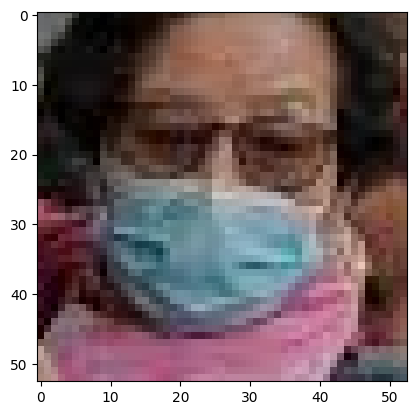

In [8]:
plt.imshow(load_img(example_with_mask))

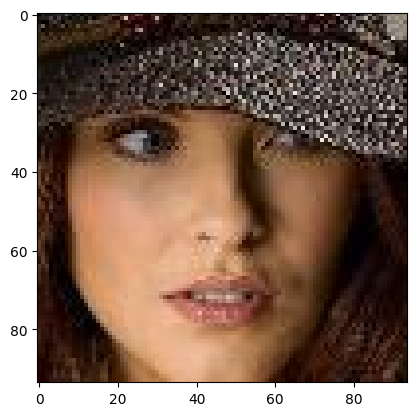

In [9]:
plt.imshow(load_img(example_without_mask))

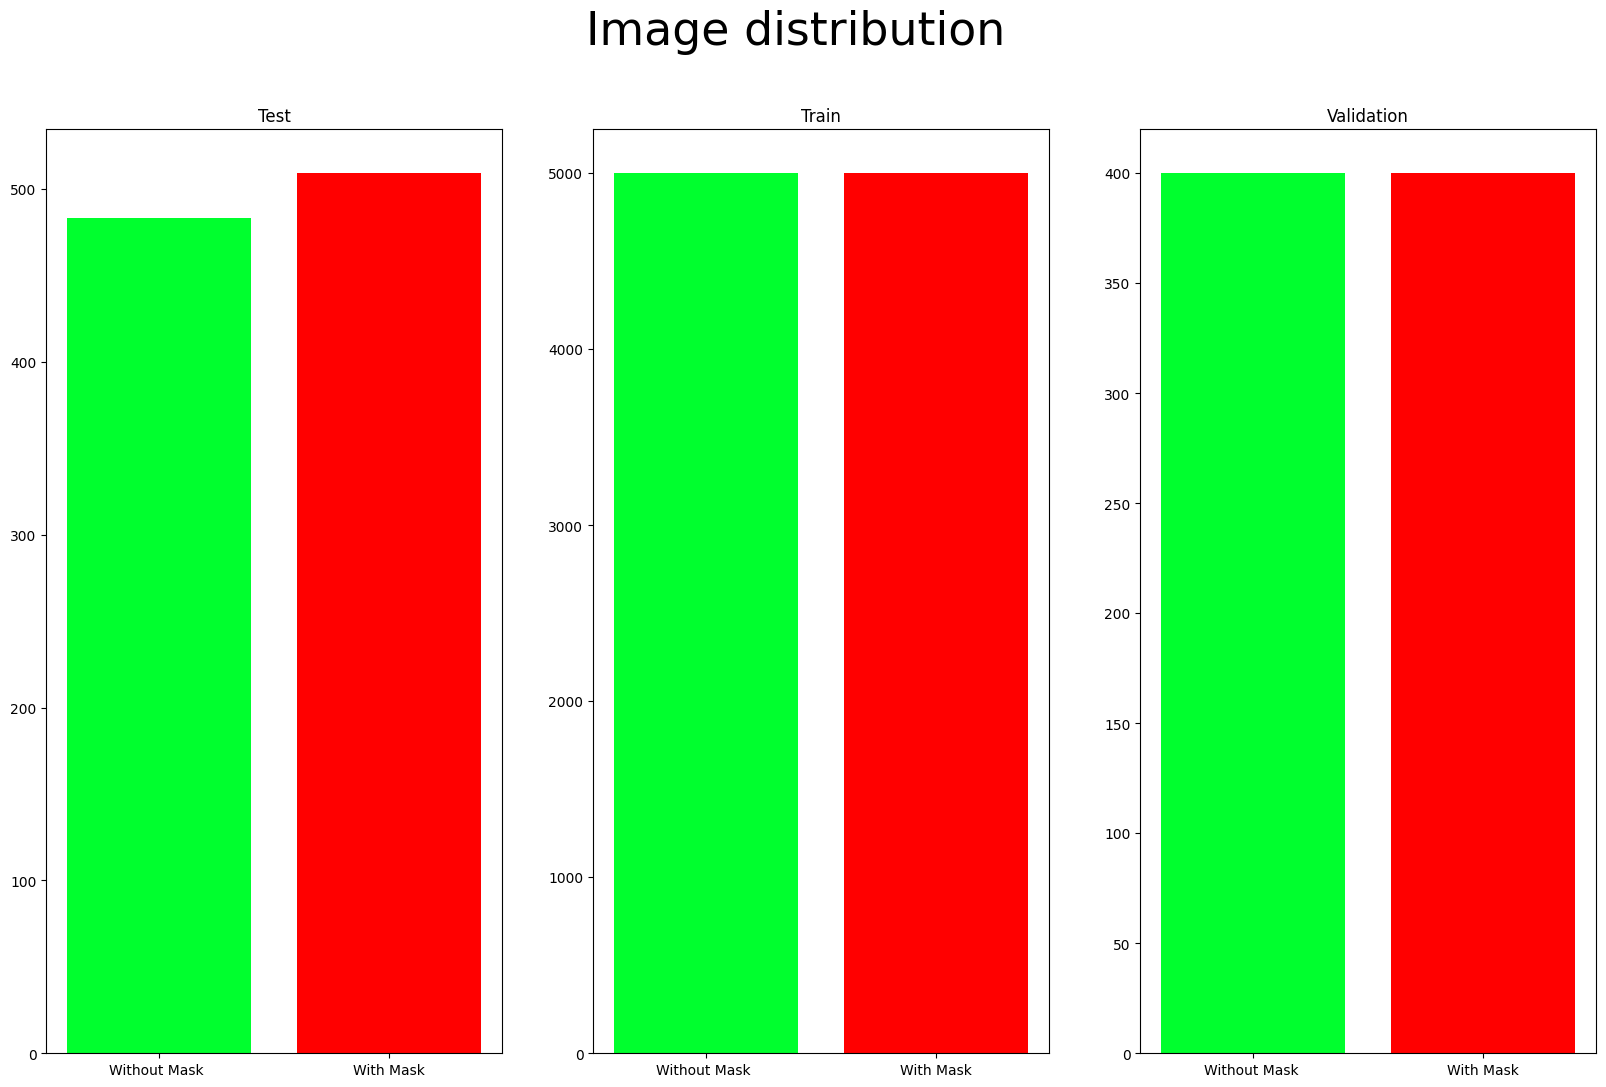

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 12))

for set_ in os.listdir(path):
    total = []
    ax = axes[os.listdir(path).index(set_)]
    for class_ in os.listdir(path+'/'+set_):
        count=len(os.listdir(path+'/'+set_+'/'+class_))
        total.append(count)
    ax.bar(CLASSES, total, color=['#00FF2E','#FF0000'])
    ax.set_title(set_)
plt.suptitle('Image distribution', size=33)
plt.show()

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   zoom_range=0.2, 
#                                    brightness_range=[0.2,1.0], 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
img = load_img(example_with_mask)
example_aug = img_to_array(img)/255.
#input have 4 axis - need to add extra empty axis for batch
example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

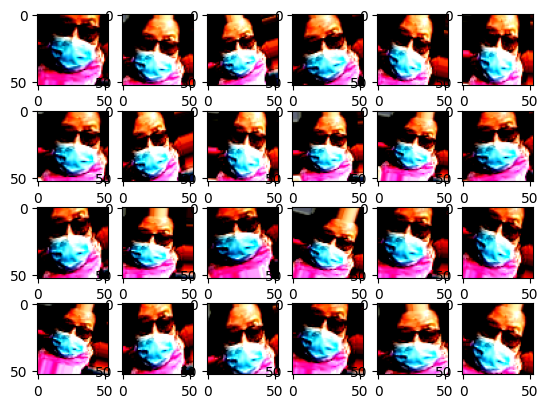

In [13]:
for i,img in enumerate(train_datagen.flow(example_aug, batch_size=1)):
    plt.subplot(4, 6, i+1)
    #remove empty axis 
    plt.imshow(np.squeeze(img))
    
    if i == 23:
        break
    
plt.show()

In [14]:
train_set = train_datagen.flow_from_directory(directory= path+'Train', batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE)
validation_set = test_datagen.flow_from_directory(path + 'Validation',target_size=TARGET_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [20]:
train_set.n

10000

In [35]:
t = train_set

In [ ]:
t.shape

In [21]:
validation_set.n

800

In [ ]:
v = validation_set
v = np.array(v)

In [11]:
denseNet_model = DenseNet201(input_shape=TARGET_SIZE + (3,), weights='imagenet', include_top=False)
denseNet_model.trainable = False
    
flatten = Flatten()(denseNet_model.layers[-1].output)
fc = Dense(units=512, activation='relu')(flatten)
dropout = Dropout(0.35)(fc)
output = Dense(2, activation='softmax')(dropout)
   
model = Model(inputs=denseNet_model.input, outputs=output)
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 flatten (Flatten)              (None, 30720)        0           ['relu[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 512)          15729152    ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dropout[0][0]']                
                                                                                                  
Total params: 34,052,162
Trainable params: 15,730,178
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [12]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 10000
learning_rate = optimizers.schedules.PolynomialDecay(starter_learning_rate,decay_steps,end_learning_rate,power=0.4)

In [13]:
# Define Optimizer, Loss & Metrics


opt = optimizers.Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [14]:
my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=5, mode='auto',restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='my_model.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
]

In [15]:
history = model.fit(train_set,
                    epochs=EPOCHS, steps_per_epoch=len(train_set), # How many mini_batchs we have inside each epoch.
                    validation_data=validation_set,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('C:/Githu/bMIT_Web2/Model/model_mask/DenseNet201_V1_preprocessing.h5')
#model.save_weights("my_model.h5")

Epoch 1/8
157/157 [==============================] - ETA: 0s - loss: 7.1592 - accuracy: 0.9797
Epoch 1: accuracy improved from -inf to 0.97970, saving model to my_model.h5
157/157 [==============================] - 861s 5s/step - loss: 7.1592 - accuracy: 0.9797 - val_loss: 0.7705 - val_accuracy: 0.9937
Epoch 2/8
157/157 [==============================] - ETA: 0s - loss: 0.9017 - accuracy: 0.9932
Epoch 2: accuracy improved from 0.97970 to 0.99320, saving model to my_model.h5
157/157 [==============================] - 764s 5s/step - loss: 0.9017 - accuracy: 0.9932 - val_loss: 0.0241 - val_accuracy: 0.9962
Epoch 3/8
157/157 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9956
Epoch 3: accuracy improved from 0.99320 to 0.99560, saving model to my_model.h5
157/157 [==============================] - 779s 5s/step - loss: 0.1610 - accuracy: 0.9956 - val_loss: 0.0228 - val_accuracy: 0.9937
Epoch 4/8
157/157 [==============================] - ETA: 0s - loss: 0.0378 - accu

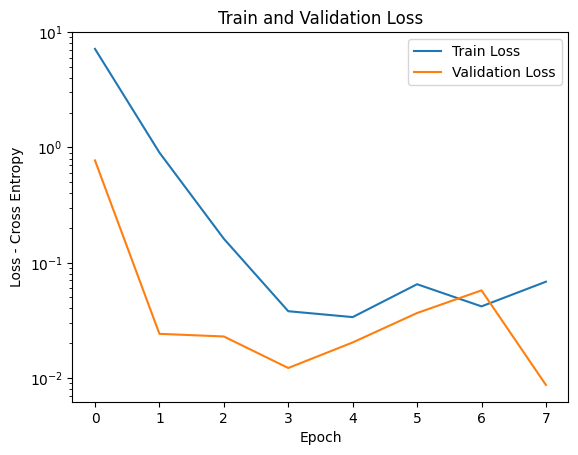

In [16]:
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
plt.semilogy(train_loss, label='Train Loss')
plt.semilogy(val_loss, label='Validation Loss')


plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')


plt.show()

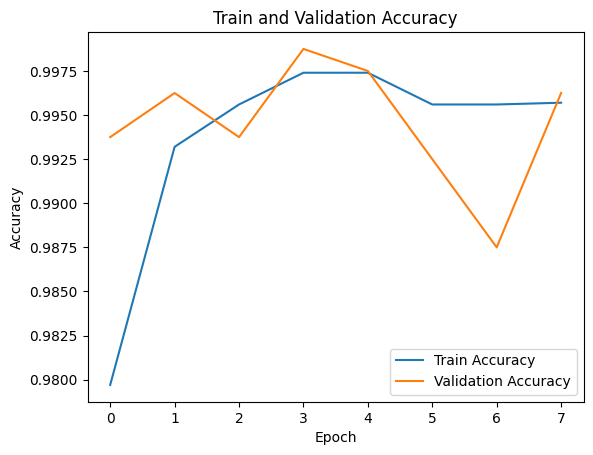

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.show()

In [22]:
test_set = test_datagen.flow_from_directory(path + 'Test',target_size=TARGET_SIZE,shuffle=False)

Found 992 images belonging to 2 classes.


In [ ]:
te = test_set
te = np.array(te)


992

In [19]:
# Model Evaluate 
loss, accuracy = model.evaluate(test_set)
print('Test Accuracy: ', '\033[1m',round(accuracy*100, 2),'%\033[0m')

31/31 [==============================] - 77s 2s/step - loss: 0.0384 - accuracy: 0.9929
Test Accuracy:   99.29 %


1/1 [==============================] - 7s 7s/step


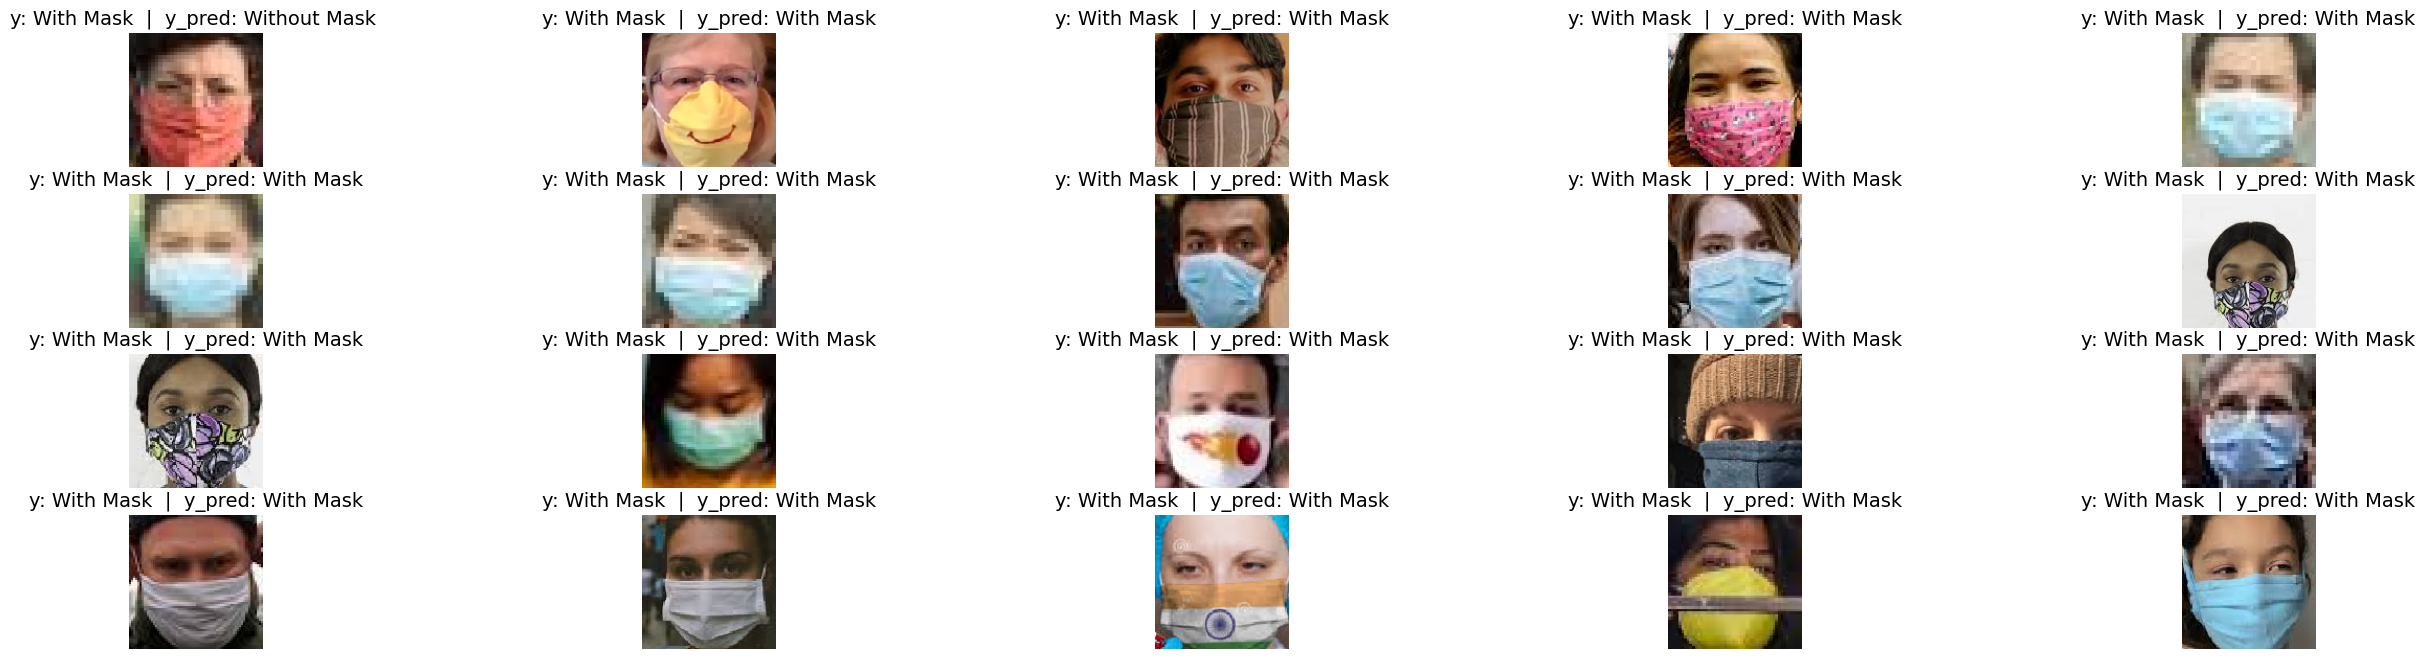

In [20]:
# True Label & Predict of a particular Batch
image, label = test_set.next()
num_imgs = 20
lab_names = ['With Mask','Without Mask ']
images = image[0:num_imgs,:,:,:]
labels = label[0:num_imgs,:]
predict = np.round(model.predict(images))

image_rows = 4
image_col = int(num_imgs/image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i,:,:,:]
    lab = labels[i,:]
    axs[i].imshow(img)
    pred = predict[i]
    axs[i].axis('off')
    lab, pred = np.argmax(lab), np.argmax(pred)
    axs[i].set_title(label = f'y: {lab_names[lab]}  |  y_pred: {lab_names[pred]}', fontsize=14)

plt.show()

In [ ]:
y_pred = model.predict(test_set).argmax(axis=-1)
y_test = test_set.classes

In [21]:
y_pred = model.predict(test_set).argmax(axis=-1)
y_test = test_set.classes

Confusion_Matrix = confusion_matrix(y_test,y_pred)

31/31 [==============================] - 81s 2s/step


Text(0.5, 1.0, 'Confusion matrix')

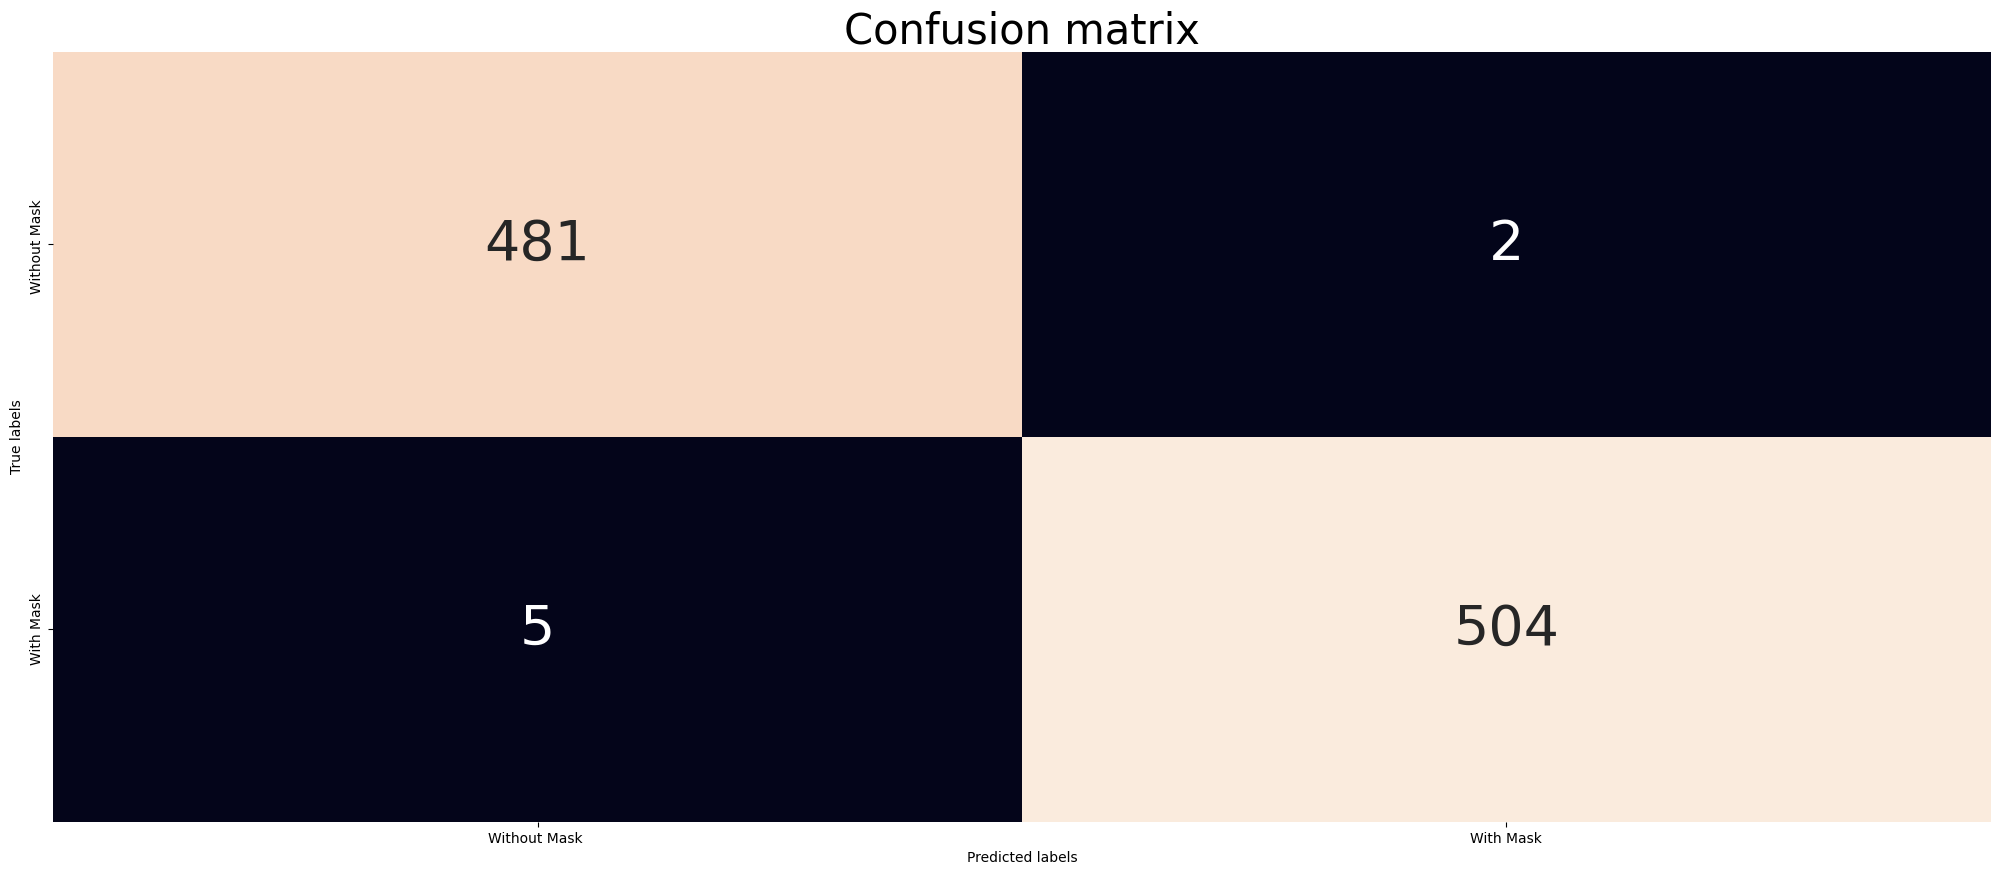

In [22]:
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(Confusion_Matrix,xticklabels=CLASSES,yticklabels=CLASSES, ax=ax, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 40})
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Confusion matrix",fontsize=30)

In [23]:
model.save('DenseNet201_V1.h5')

In [24]:
len(train_set)

157

In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import ZeroPadding2D,AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

x = base_model.output
# x = ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)


model2 = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(lr=1e-2), metrics=['accuracy'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [26]:
# Train the model
history = model2.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=20,
    validation_data=validation_set,
    validation_steps=len(validation_set)
)

Epoch 1/20
157/157 [==============================] - 155s 955ms/step - loss: 0.1079 - accuracy: 0.9662 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 2/20
157/157 [==============================] - 146s 932ms/step - loss: 0.0468 - accuracy: 0.9852 - val_loss: 0.0602 - val_accuracy: 0.9787
Epoch 3/20
157/157 [==============================] - 147s 936ms/step - loss: 0.0426 - accuracy: 0.9864 - val_loss: 0.0564 - val_accuracy: 0.9825
Epoch 4/20
157/157 [==============================] - 141s 896ms/step - loss: 0.0309 - accuracy: 0.9897 - val_loss: 0.0466 - val_accuracy: 0.9875
Epoch 5/20
157/157 [==============================] - 141s 894ms/step - loss: 0.0337 - accuracy: 0.9882 - val_loss: 0.0497 - val_accuracy: 0.9850
Epoch 6/20
157/157 [==============================] - 138s 878ms/step - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0487 - val_accuracy: 0.9812
Epoch 7/20
157/157 [==============================] - 139s 882ms/step - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.0549 -

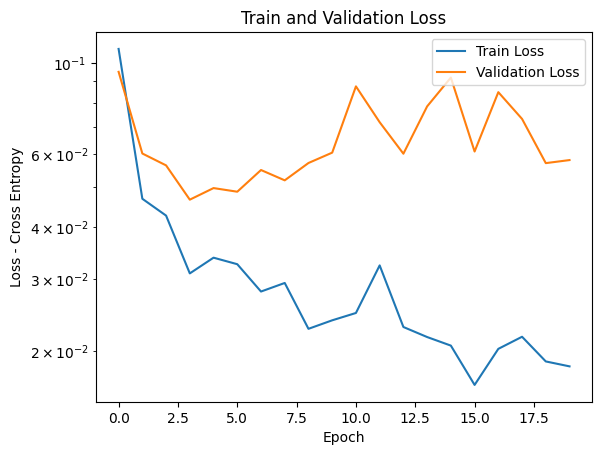

In [27]:
train_loss2 = np.array(history.history['loss'])
val_loss2 = np.array(history.history['val_loss'])
plt.semilogy(train_loss2, label='Train Loss')
plt.semilogy(val_loss2, label='Validation Loss')


plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')


plt.show()

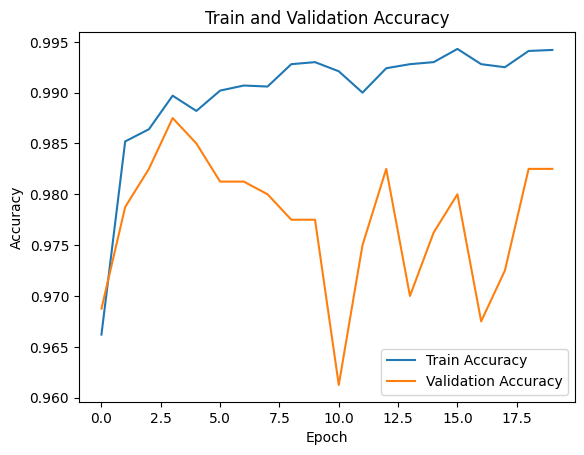

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.show()

In [29]:
# Model Evaluate 
loss, accuracy = model2.evaluate(test_set)
print('Test Accuracy: ', '\033[1m',round(accuracy*100, 2),'%\033[0m')

31/31 [==============================] - 10s 334ms/step - loss: 0.0521 - accuracy: 0.9788
Test Accuracy:   97.88 %


1/1 [==============================] - 1s 1s/step


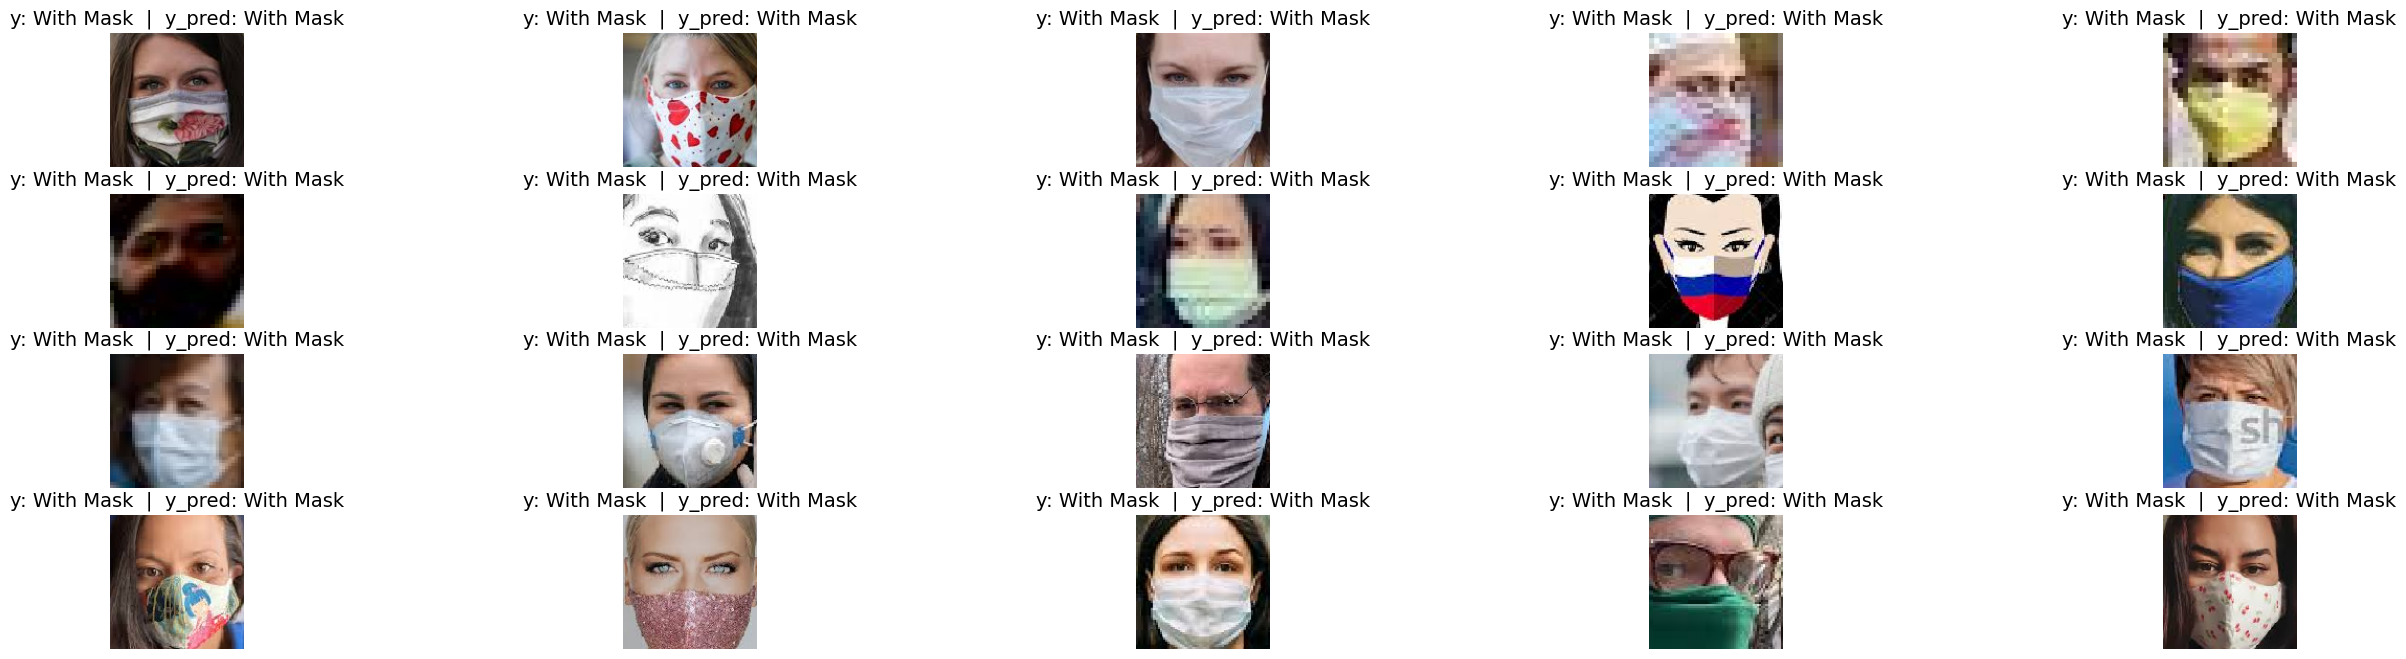

In [30]:
# True Label & Predict of a particular Batch
image, label = test_set.next()
num_imgs = 20
lab_names = ['With Mask','Without Mask ']
images = image[0:num_imgs,:,:,:]
labels = label[0:num_imgs,:]
predict = np.round(model2.predict(images))

image_rows = 4
image_col = int(num_imgs/image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i,:,:,:]
    lab = labels[i,:]
    axs[i].imshow(img)
    pred = predict[i]
    axs[i].axis('off')
    lab, pred = np.argmax(lab), np.argmax(pred)
    axs[i].set_title(label = f'y: {lab_names[lab]}  |  y_pred: {lab_names[pred]}', fontsize=14)

plt.show()

In [31]:
y_pred = model2.predict(test_set).argmax(axis=-1)
y_test = test_set.classes

Confusion_Matrix = confusion_matrix(y_test,y_pred)

31/31 [==============================] - 13s 384ms/step


Text(0.5, 1.0, 'Confusion matrix')

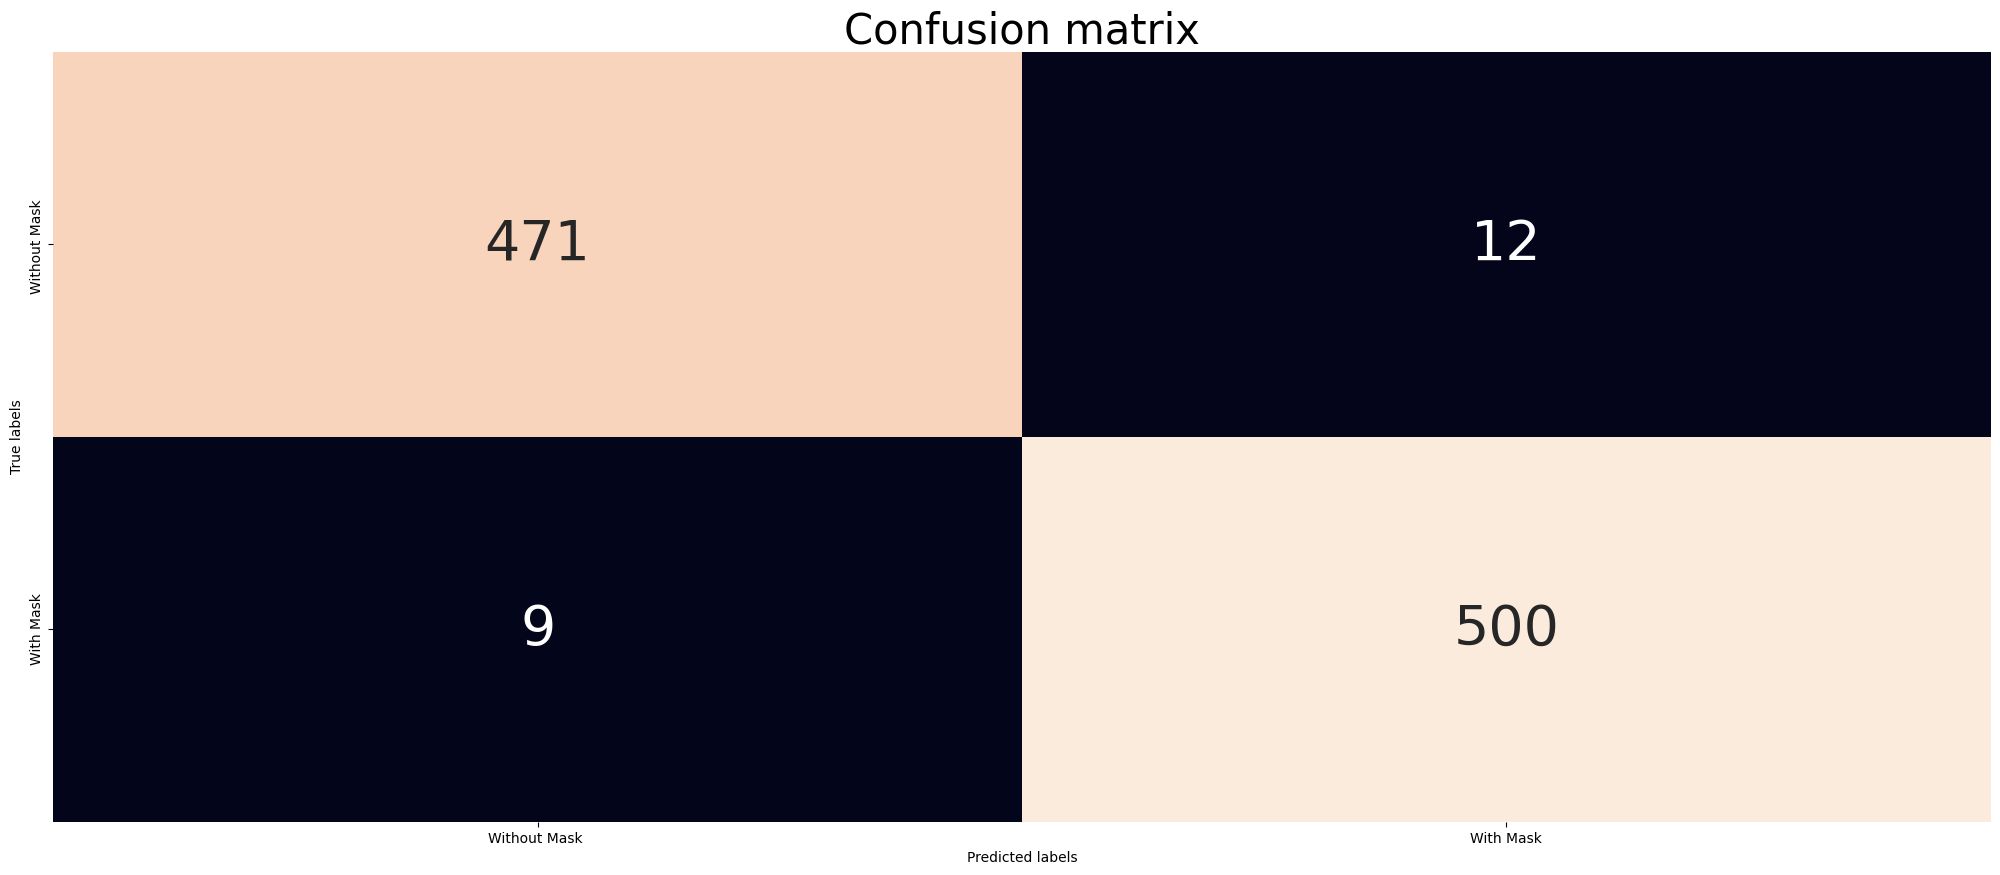

In [32]:
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(Confusion_Matrix,xticklabels=CLASSES,yticklabels=CLASSES, ax=ax, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 40})
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Confusion matrix",fontsize=30)

In [33]:
model2.save('C:/Github/MIT_Web2/Model/model_mask/MoblieNetV2_V2.h5')